In [1]:
import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from data_grunwald import get_data


/Users/nsq277/opt/anaconda3/envs/cold_pac/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
# set seed
seed = 0
np.random.seed(seed)

# get data
y = 0.0
d_x = 101  # number of fourier features
n_train = 100
n_test = 10000
if_misspecified = False
X_train, Y_train, _ = get_data(
    y=y, d_x=d_x, n_data=n_train, if_misspecified=if_misspecified
)
X_test, Y_test, _ = get_data(
    y=y, d_x=d_x, n_data=n_test, if_misspecified=if_misspecified
)


In [49]:
def get_measures(var_prior, X_train, Y_train, X_test, Y_test):
    log_risks = []  # for bayesian posterior predictive
    r_log_risks = []  # for expected gibbs loss
    emp_r_log_risks = []
    kls = []  # kl between posterior and prior
    vars_prior_pred = []  # prior predictive variance
    lambs = np.linspace(0.1, 1.5, 20)
    for lamb in lambs:

        print(lamb)
        print()

        # settings
        # prior
        var_prior = torch.tensor(var_prior)
        n_prior_samples = 5000  # no. of samples from prior
        # likelihood
        var_likelihood = torch.tensor(0.025)
        # posterior
        n_post_samples = 5000  # no. of samples from posterior

        # compute posterior distribution, see bishop eq 3.53 and 3.54
        # X_train is the design matrix, n_train by d_x matrix
        alpha = var_prior ** (-1)  # prior recision
        beta_orig = var_likelihood ** (
            -1
        )  # gaussian likelihood precision before absorbing temperature
        beta = (
            beta_orig * lamb
        )  # gaussian likelihood precision after absorbing temperature
        S_N_inv = (
            alpha * torch.eye(d_x) + beta * X_train.T @ X_train
        )  # posterior precision
        S_N = torch.inverse(S_N_inv)  # posterior variance
        m_N = beta * S_N @ X_train.T @ Y_train  # posterior mean
        p_post = MultivariateNormal(m_N.reshape(-1), precision_matrix=S_N_inv)

        # computre posterior predictive distribution, see bishop eq 3.58 and 3.59
        mean_post_pred = X_test @ m_N
        cov_post_pred = torch.eye(n_test) / beta + X_test @ S_N @ X_test.T
        std_post_pred = torch.sqrt(torch.diag(cov_post_pred))
        p_post_pred = Normal(mean_post_pred, std_post_pred)

        # get expected gibbs loss
        samples_post = p_post.sample((n_post_samples,))
        r_log_risk = (
            -Normal(X_test @ samples_post.T, torch.sqrt(var_likelihood / lamb))
            .log_prob(Y_test.reshape(-1, 1))
            .mean()
            .item()
        )
        r_log_risks.append(r_log_risk)

        # get empirical gibbs loss
        emp_r_log_risk = (
            -Normal(X_train @ samples_post.T, torch.sqrt(var_likelihood / lamb))
            .log_prob(Y_train.reshape(-1, 1))
            .mean()
            .item()
        )
        emp_r_log_risks.append(emp_r_log_risk)

        # get bayesian generalization loss
        log_risk = -p_post_pred.log_prob(Y_test).mean().item()
        log_risks.append(log_risk)

        # prior predictive variance
        p_prior = MultivariateNormal(torch.zeros(d_x), torch.eye(d_x) * var_prior)
        samples_prior = p_prior.sample((n_prior_samples,))
        var_prior_pred = (
            torch.var(
                -Normal(X_train @ samples_prior.T, torch.sqrt(var_likelihood)).log_prob(
                    Y_train.reshape(-1, 1)
                ),
                0,
            )
            .mean()
            .item()
        )
        vars_prior_pred.append(var_prior_pred)

        # kl
        kl = torch.distributions.kl.kl_divergence(p_post, p_prior).item()
        kls.append(kl)

    return log_risks, r_log_risks, emp_r_log_risks, kls, vars_prior_pred


In [50]:
var_prior_1 = 0.01
var_prior_2 = 1.0
var_prior_3 = 100.0


In [51]:
(
    log_risks_001,
    r_log_risks_001,
    emp_r_log_risks_001,
    kls_001,
    vars_prior_pred_001,
) = get_measures(var_prior_1, X_train, Y_train, X_test, Y_test)
log_risks_1, r_log_risks_1, emp_r_log_risks_1, kls_1, vars_prior_pred_1 = get_measures(
    var_prior_2, X_train, Y_train, X_test, Y_test
)
(
    log_risks_100,
    r_log_risks_100,
    emp_r_log_risks_100,
    kls_100,
    vars_prior_pred_100,
) = get_measures(var_prior_3, X_train, Y_train, X_test, Y_test)


0.1

0.17368421052631577



/var/folders/xf/5w99rbbs1g79w78bqgk29z2m0000gp/T/ipykernel_11253/699745615.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_prior = torch.tensor(var_prior)


0.24736842105263157

0.32105263157894737

0.39473684210526316

0.46842105263157896

0.5421052631578946

0.6157894736842104

0.6894736842105262

0.763157894736842

0.8368421052631578

0.9105263157894736

0.9842105263157893

1.0578947368421052

1.131578947368421

1.2052631578947368

1.2789473684210526

1.3526315789473684

1.4263157894736842

1.5

0.1

0.17368421052631577

0.24736842105263157

0.32105263157894737

0.39473684210526316

0.46842105263157896

0.5421052631578946

0.6157894736842104

0.6894736842105262

0.763157894736842

0.8368421052631578

0.9105263157894736

0.9842105263157893

1.0578947368421052

1.131578947368421

1.2052631578947368

1.2789473684210526

1.3526315789473684

1.4263157894736842

1.5

0.1

0.17368421052631577

0.24736842105263157

0.32105263157894737

0.39473684210526316

0.46842105263157896

0.5421052631578946

0.6157894736842104

0.6894736842105262

0.763157894736842

0.8368421052631578

0.9105263157894736

0.9842105263157893

1.0578947368421052

1.131578947

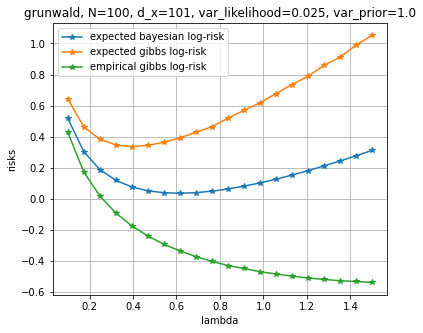

In [68]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, log_risks_1, "-*", label="expected bayesian log-risk")
plt.plot(lambs, r_log_risks_1, "-*", label="expected gibbs log-risk")
plt.plot(lambs, emp_r_log_risks_1, "-*", label="empirical gibbs log-risk")

plt.xlabel("lambda")
plt.ylabel("risks")
plt.title(
    f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025, var_prior={var_prior_2}"
)
plt.legend()
plt.savefig("grunwald_risks.jpg", bbox_inches="tight")
plt.show()


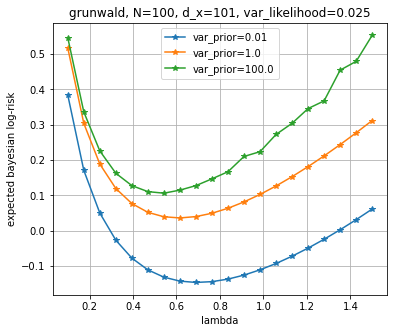

In [63]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, log_risks_001, "-*", label=f"var_prior={var_prior_1}")
plt.plot(lambs, log_risks_1, "-*", label=f"var_prior={var_prior_2}")
plt.plot(lambs, log_risks_100, "-*", label=f"var_prior={var_prior_3}")

plt.xlabel("lambda")
plt.ylabel("expected bayesian log-risk")
plt.title(f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025")
plt.legend()
plt.savefig("grunwald_log_risk.jpg", bbox_inches="tight")
plt.show()


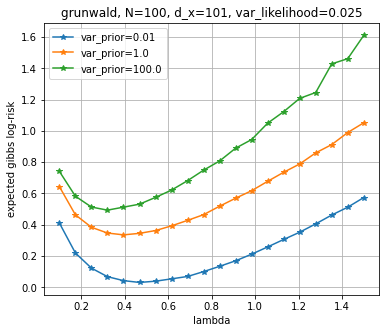

In [64]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, r_log_risks_001, "-*", label=f"var_prior={var_prior_1}")
plt.plot(lambs, r_log_risks_1, "-*", label=f"var_prior={var_prior_2}")
plt.plot(lambs, r_log_risks_100, "-*", label=f"var_prior={var_prior_3}")

plt.xlabel("lambda")
plt.ylabel("expected gibbs log-risk")
plt.title(f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025")
plt.legend()
plt.savefig("grunwald_r_log_risk.jpg", bbox_inches="tight")
plt.show()


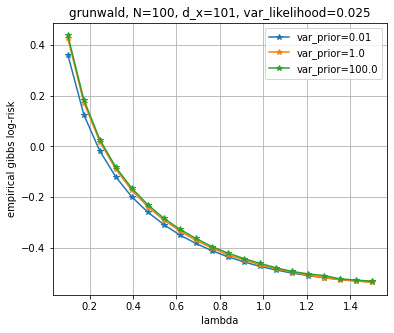

In [65]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, emp_r_log_risks_001, "-*", label=f"var_prior={var_prior_1}")
plt.plot(lambs, emp_r_log_risks_1, "-*", label=f"var_prior={var_prior_2}")
plt.plot(lambs, emp_r_log_risks_100, "-*", label=f"var_prior={var_prior_3}")

plt.xlabel("lambda")
plt.ylabel("empirical gibbs log-risk")
plt.title(f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025")
plt.legend()
plt.savefig("grunwald_emp_r_log_risk.jpg", bbox_inches="tight")
plt.show()


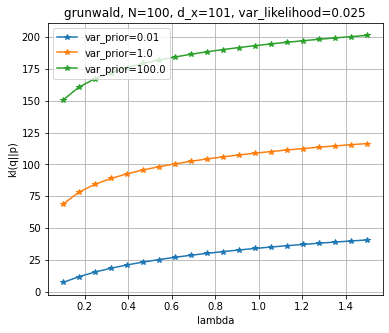

In [66]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, kls_001, "-*", label=f"var_prior={var_prior_1}")
plt.plot(lambs, kls_1, "-*", label=f"var_prior={var_prior_2}")
plt.plot(lambs, kls_100, "-*", label=f"var_prior={var_prior_3}")

plt.xlabel("lambda")
plt.ylabel("kl(q||p)")
plt.title(f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025")
plt.legend()
plt.savefig("grunwald_kl.jpg", bbox_inches="tight")
plt.show()


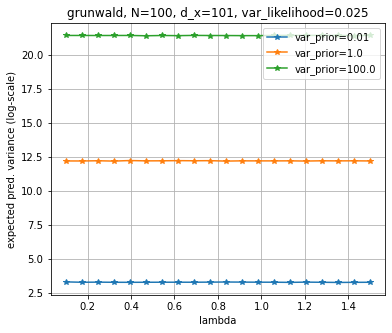

In [67]:
fig = plt.figure(figsize=(6, 5))
plt.grid()
lambs = np.linspace(0.1, 1.5, 20)
plt.plot(lambs, np.log(vars_prior_pred_001), "-*", label=f"var_prior={var_prior_1}")
plt.plot(lambs, np.log(vars_prior_pred_1), "-*", label=f"var_prior={var_prior_2}")
plt.plot(lambs, np.log(vars_prior_pred_100), "-*", label=f"var_prior={var_prior_3}")

plt.xlabel("lambda")
plt.ylabel("expected pred. variance (log-scale)")
plt.title(f"grunwald, N={n_train}, d_x={d_x}, var_likelihood=0.025")
plt.legend()
plt.savefig("grunwald_var.jpg", bbox_inches="tight")
plt.show()
